# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

train_emotion_dir = EMOTION_FILE_PATH / 'images/train'
test_emotion_dir = EMOTION_FILE_PATH / 'images/validation'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
        'label': [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH)
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH)
print(gender_df.head())

                                        file_path file_name label
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png   057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png   057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png   057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png   057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png   057
                                           file_path            file_name  \
0  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_112131.jpg   
1  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_133142.jpg   
2  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160304.jpg   
3  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240609_200332.jpg   
4  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160729.jpg   

  label  
0   MEN  
1   MEN  
2   MEN  
3   MEN  
4   MEN  


In [11]:
# Train Emotion Dataset
train_emotion_df = convert_to_df(train_emotion_dir)
train_emotion_df.head()

,file_path,file_name,label
0,/kaggle/input/facial-emotion-expressions/image...,30778.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,22706.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,20513.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,27582.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,33678.jpg,surprise


In [12]:
train_emotion_df['file_path'][0]

PosixPath('/kaggle/input/facial-emotion-expressions/images/train/surprise/30778.jpg')

In [13]:
# Test Emotion Dataset
test_emotion_df = convert_to_df(test_emotion_dir)
test_emotion_df.head()

,file_path,file_name,label
0,/kaggle/input/facial-emotion-expressions/image...,13288.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,24201.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,26556.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,26076.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,27577.jpg,surprise


In [14]:
test_emotion_df['file_path'][0]

PosixPath('/kaggle/input/facial-emotion-expressions/images/validation/surprise/13288.jpg')

In [15]:
age_df.shape, gender_df.shape, train_emotion_df.shape, test_emotion_df.shape

((19556, 3), (1937, 3), (28821, 3), (7066, 3))

In [16]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'label']).sum())
gender_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in train emotion dataset
print(train_emotion_df.duplicated(['file_name', 'label']).sum())
train_emotion_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in test emotion dataset
print(test_emotion_df.duplicated(['file_name', 'label']).sum())
test_emotion_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778
646
0
0


In [17]:
age_df.shape, gender_df.shape

((9778, 3), (1291, 3))

In [18]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [19]:
gender_df['label'] = gender_df['label'].str.lower()
gender_df.head()

,file_path,file_name,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_112131.jpg,men
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_133142.jpg,men
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160304.jpg,men
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_200332.jpg,men
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160729.jpg,men


In [20]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

print(train_emotion_df.isnull().sum())
train_emotion_df.dropna(inplace=True)

print(test_emotion_df.isnull().sum())
test_emotion_df.dropna(inplace=True)

file_path         0
file_name         0
label             0
age_category    794
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64


In [21]:
train_emotion_df.drop(train_emotion_df[train_emotion_df['label'] == 'disgust'].index, inplace=True)
print(train_emotion_df.shape)
train_emotion_df.head()

(28385, 3)


,file_path,file_name,label
0,/kaggle/input/facial-emotion-expressions/image...,30778.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,22706.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,20513.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,27582.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,33678.jpg,surprise


In [22]:
test_emotion_df.drop(test_emotion_df[test_emotion_df['label'] == 'disgust'].index, inplace=True)
print(test_emotion_df.shape)
test_emotion_df.head()

(6955, 3)


,file_path,file_name,label
0,/kaggle/input/facial-emotion-expressions/image...,13288.jpg,surprise
1,/kaggle/input/facial-emotion-expressions/image...,24201.jpg,surprise
2,/kaggle/input/facial-emotion-expressions/image...,26556.jpg,surprise
3,/kaggle/input/facial-emotion-expressions/image...,26076.jpg,surprise
4,/kaggle/input/facial-emotion-expressions/image...,27577.jpg,surprise


In [23]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [24]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [25]:
import pandas as pd
from sklearn.utils import resample

# Function to balance the dataset to have exactly 'n' samples per category
def balance_dataframe(dataframe, label_col, n):
    balanced_dfs = []
    for category, group in dataframe.groupby(label_col, observed=False):
        if len(group) >= n:
            balanced_dfs.append(group.sample(n=n, random_state=42))
        else:
            # Retain all samples if the group has fewer than 'n' samples
            balanced_dfs.append(group)
    
    return pd.concat(balanced_dfs).reset_index(drop=True)  # Convert list to DataFrame

In [26]:
# Apply function to balance the age dataset
age_balanced_df = balance_dataframe(dataframe=age_df, label_col='age_category', n=1000)

# Display the first few rows
print(age_balanced_df.head())
age_balanced_df['age_category'].value_counts()

                                        file_path file_name age_category
0  /kaggle/input/facial-age/face_age/001/2080.png  2080.png         Baby
1  /kaggle/input/facial-age/face_age/002/6050.png  6050.png         Baby
2  /kaggle/input/facial-age/face_age/002/2680.png  2680.png         Baby
3  /kaggle/input/facial-age/face_age/001/8335.png  8335.png         Baby
4  /kaggle/input/facial-age/face_age/001/1266.png  1266.png         Baby


age_category
Baby           1000
Child          1000
Young Adult    1000
Adult          1000
Elderly        1000
Teen            957
Name: count, dtype: int64

In [27]:
# Apply function to balance the train emotion dataset
train_emotion_data = balance_dataframe(dataframe=train_emotion_df, label_col='label', n=3000)

# Display the first few rows
print(train_emotion_data.head())
train_emotion_data['label'].value_counts()

                                           file_path  file_name  label
0  /kaggle/input/facial-emotion-expressions/image...  34079.jpg  angry
1  /kaggle/input/facial-emotion-expressions/image...    117.jpg  angry
2  /kaggle/input/facial-emotion-expressions/image...  35611.jpg  angry
3  /kaggle/input/facial-emotion-expressions/image...  14029.jpg  angry
4  /kaggle/input/facial-emotion-expressions/image...  14501.jpg  angry


label
angry       3000
fear        3000
happy       3000
neutral     3000
sad         3000
surprise    3000
Name: count, dtype: int64

In [28]:
# Apply function to balance the test emotion dataset
test_emotion_data = balance_dataframe(dataframe=test_emotion_df, label_col='label', n=800)

# Display the first few rows
print(test_emotion_data.head())
test_emotion_data['label'].value_counts()

                                           file_path  file_name  label
0  /kaggle/input/facial-emotion-expressions/image...  28058.jpg  angry
1  /kaggle/input/facial-emotion-expressions/image...  22183.jpg  angry
2  /kaggle/input/facial-emotion-expressions/image...  28560.jpg  angry
3  /kaggle/input/facial-emotion-expressions/image...   6766.jpg  angry
4  /kaggle/input/facial-emotion-expressions/image...  23085.jpg  angry


label
angry       800
fear        800
happy       800
neutral     800
sad         800
surprise    797
Name: count, dtype: int64

In [29]:
train_age_data, test_age_data = train_test_split(age_balanced_df, shuffle=True, test_size=0.2)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.2)
train_gender_data.head()

                                           file_path file_name age_category
648   /kaggle/input/facial-age/face_age/002/6617.png  6617.png         Baby
3998  /kaggle/input/facial-age/face_age/030/6882.png  6882.png        Adult
2730  /kaggle/input/facial-age/face_age/014/5845.png  5845.png         Teen
5028  /kaggle/input/facial-age/face_age/060/2816.png  2816.png      Elderly
1033  /kaggle/input/facial-age/face_age/008/3325.png  3325.png        Child


,file_path,file_name,label
773,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0279.jpg,woman
99,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_101808.jpg,men
704,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0056.jpg,woman
257,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_183700.jpg,men
950,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0352.jpg,woman


In [30]:
train_age_data.shape, test_age_data.shape

((4765, 3), (1192, 3))

In [31]:
train_gender_data.shape, test_gender_data.shape

((1032, 3), (259, 3))

In [32]:
train_emotion_data.shape, test_emotion_data.shape

((18000, 3), (4797, 3))

## 3. Data Transformation for All Dataset

In [33]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for Age and Gender Data

In [34]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, file_paths, categories, idx, transform=None):
        """
        Args:
            file_paths (list): List of image file paths.
            categories (list): List of all categories corresponding to the images.
            idx (dict): Mapping of all categories to numerical indices.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.file_paths = list(file_paths)
        self.categories = list(categories)
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Retrieve image path and age category
        img_path = self.file_paths[idx]
        category = self.categories[idx]

        # Map the age category to its corresponding index
        label_idx = self.idx[category]

        # Load the image
        img = Image.open(img_path)

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [35]:
gender_labels = list(train_gender_data['label'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'woman': 0, 'men': 1}

In [36]:
emotion_labels = list(train_emotion_data['label'].unique())
emotion_idx = {label:i for i, label in enumerate(emotion_labels)}

emotion_idx

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [37]:
# Initialize the datasets for Age Dataset
age_train_dataset = CustomDataset(
    file_paths=train_age_data['file_path'].tolist(),
    categories=train_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=train_transforms
)

age_test_dataset = CustomDataset(
    file_paths=test_age_data['file_path'].tolist(),
    categories=test_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=test_transforms
)

# Initialize the datasets for Gender Dataset
gender_train_dataset = CustomDataset(
    file_paths=train_gender_data['file_path'].tolist(),
    categories=train_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=train_transforms
)

gender_test_dataset = CustomDataset(
    file_paths=test_gender_data['file_path'].tolist(),
    categories=test_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=test_transforms
)

# Initialize the datasets for Emotion Dataset
emotion_train_dataset = CustomDataset(
    file_paths=train_emotion_data['file_path'].tolist(),
    categories=train_emotion_data['label'].tolist(),
    idx=emotion_idx,
    transform=train_transforms
)

emotion_test_dataset = CustomDataset(
    file_paths=test_emotion_data['file_path'].tolist(),
    categories=test_emotion_data['label'].tolist(),
    idx=gender_idx,
    transform=test_transforms
)

In [38]:
# Test the training dataset
img, label_idx = age_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 0


In [39]:
# Test the training dataset
img, label_idx = gender_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 0


In [40]:
age_train_dataset[3]

(tensor([[[-0.5424, -0.5253, -0.5082,  ..., -0.6623, -0.6794, -0.6623],
          [-0.5424, -0.5253, -0.5082,  ..., -0.6965, -0.7308, -0.7137],
          [-0.5424, -0.5253, -0.5082,  ..., -0.7137, -0.7479, -0.7308],
          ...,
          [ 0.3652,  0.4508,  0.4851,  ...,  0.1939,  0.1768,  0.1426],
          [ 0.3823,  0.4851,  0.5364,  ...,  0.2282,  0.1939,  0.1768],
          [ 0.3823,  0.4851,  0.5364,  ...,  0.2453,  0.2282,  0.1939]],
 
         [[-0.3901, -0.3725, -0.3550,  ..., -0.3725, -0.3901, -0.3725],
          [-0.3901, -0.3725, -0.3550,  ..., -0.4076, -0.4426, -0.4251],
          [-0.3901, -0.3725, -0.3550,  ..., -0.4251, -0.4601, -0.4426],
          ...,
          [ 0.6779,  0.7654,  0.8004,  ...,  0.2227,  0.2402,  0.2577],
          [ 0.6954,  0.8004,  0.8529,  ...,  0.2402,  0.2402,  0.2577],
          [ 0.6954,  0.8004,  0.8529,  ...,  0.2402,  0.2402,  0.2402]],
 
         [[-0.4101, -0.3927, -0.3753,  ..., -0.5670, -0.6018, -0.5844],
          [-0.4101, -0.3927,

In [41]:
gender_train_dataset[3]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [42]:
emotion_train_dataset[3]

(tensor([[[-1.3815, -1.3815, -1.3815,  ...,  2.2489,  2.2489,  2.2489],
          [-1.3815, -1.3815, -1.3815,  ...,  2.2489,  2.2489,  2.2489],
          [-1.3815, -1.3815, -1.3815,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [ 0.2624,  0.2624,  0.2624,  ..., -1.4500, -1.4500, -1.4500],
          [ 0.2624,  0.2624,  0.2624,  ..., -1.4500, -1.4500, -1.4500],
          [ 0.2624,  0.2624,  0.2624,  ..., -1.4500, -1.4500, -1.4500]],
 
         [[-1.2829, -1.2829, -1.2829,  ...,  2.4286,  2.4286,  2.4286],
          [-1.2829, -1.2829, -1.2829,  ...,  2.4286,  2.4286,  2.4286],
          [-1.2829, -1.2829, -1.2829,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 0.3978,  0.3978,  0.3978,  ..., -1.3529, -1.3529, -1.3529],
          [ 0.3978,  0.3978,  0.3978,  ..., -1.3529, -1.3529, -1.3529],
          [ 0.3978,  0.3978,  0.3978,  ..., -1.3529, -1.3529, -1.3529]],
 
         [[-1.0550, -1.0550, -1.0550,  ...,  2.6400,  2.6400,  2.6400],
          [-1.0550, -1.0550,

In [43]:
age_train_dataset.idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

In [44]:
gender_train_dataset.idx

{'woman': 0, 'men': 1}

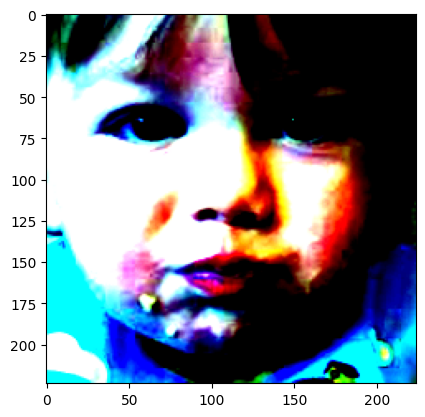

In [45]:
plt.imshow(age_train_dataset[0][0].permute(1, 2, 0))

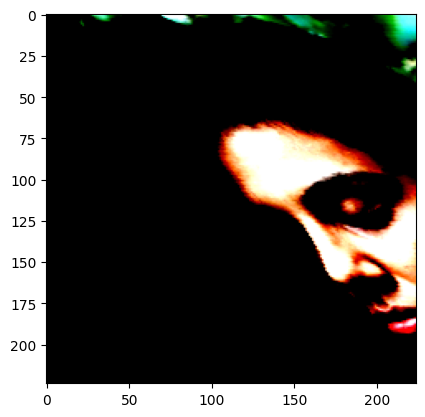

In [46]:
plt.imshow(gender_train_dataset[0][0].permute(1, 2, 0))

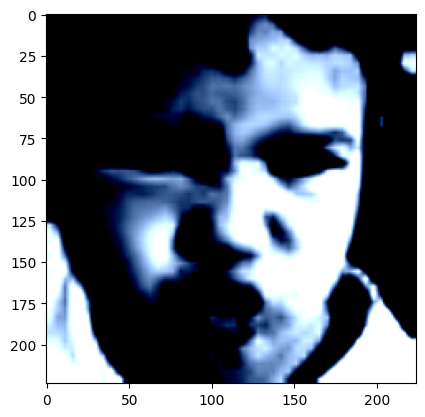

In [47]:
plt.imshow(emotion_train_dataset[4][0].permute(1, 2, 0))

In [48]:
import matplotlib.pyplot as plt

# Adjusted display_random_images function
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, label = dataset[idx]
        
        # Convert the tensor to numpy for matplotlib
        img_np = img_tensor.permute(1, 2, 0).numpy()

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        
        title = f"Class: {classes[label]}" if classes and label < len(classes) else f"Label: {label}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title)

    plt.show()

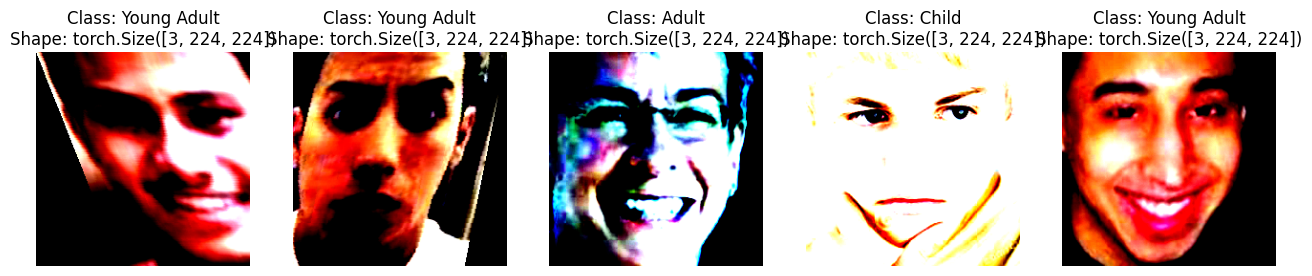

In [49]:
# Display random images from the the Custom Dataset
display_random_images(age_train_dataset, n=5,
                     classes=age_labels, seed=None)

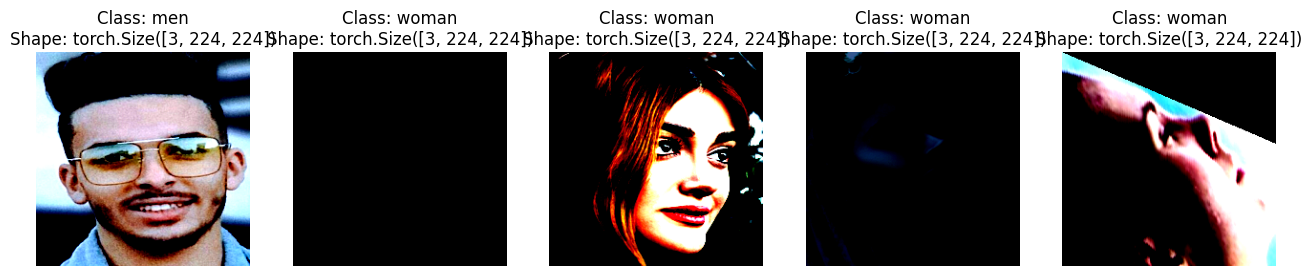

In [50]:
# Display random images from the the Custom Dataset
display_random_images(gender_train_dataset, n=5,
                     classes=gender_labels, seed=None)

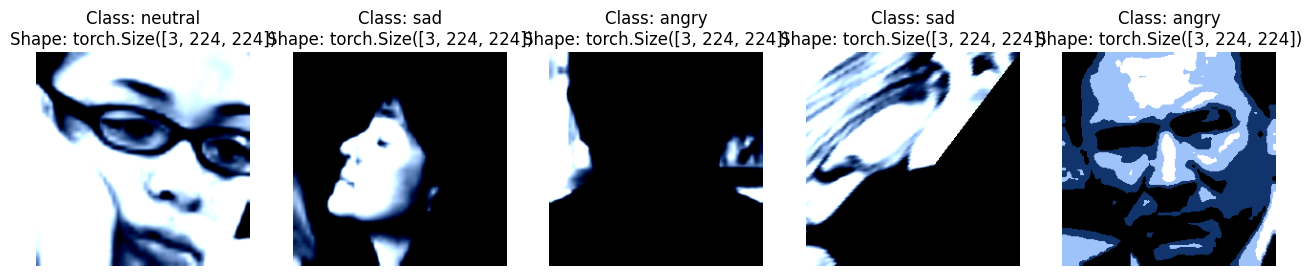

In [51]:
# Display random images from the the Custom Dataset
display_random_images(emotion_train_dataset, n=5,
                     classes=emotion_labels, seed=None)

## 5. Turn all Dataset into DataLoader

## Model Architecture 